In [1]:
# pip install pandas datasets numpy matplotlib seaborn faiss-cpu umap-learn wordcloud nltk textblob scikit-learn sentence-transformers transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 7.0 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 35.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 55.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 85.9 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━

Note: you may need to restart the kernel to use updated packages.


In [2]:
import faiss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import datasets
import re
from datasets import Dataset
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error
from textblob import TextBlob
from torch.nn.functional import cross_entropy
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer
import string
import nltk
from nltk.corpus import stopwords
import math

In [20]:
# Membaca data
df = pd.read_csv('Data.csv')

# Menggabungkan teks kategori, judul, dan komentar untuk tiap entri
df['text_combined'] = df['category'] + ' ' + df['title'] + ' ' + df['comment']

# Memuat model SBERT pre-trained
model = SentenceTransformer('all-MiniLM-L6-v2')

# Menghasilkan embedding vektor untuk setiap entri
embeddings = model.encode(df['text_combined'].tolist(),show_progress_bar=True)
df['SBERT_Embedding'] = embeddings.tolist()

print("Jumlah entri:", len(embeddings))
print("Dimensi vektor embedding:", len(embeddings[0]))
print("Contoh embedding untuk entri pertama:", embeddings[0][:5], "...")  # tampilkan 5 nilai awal


Batches:   0%|          | 0/32834 [00:00<?, ?it/s]

Jumlah entri: 1050678
Dimensi vektor embedding: 384
Contoh embedding untuk entri pertama: [-0.06785443 -0.00142894  0.04765468  0.0111813   0.04943212] ...


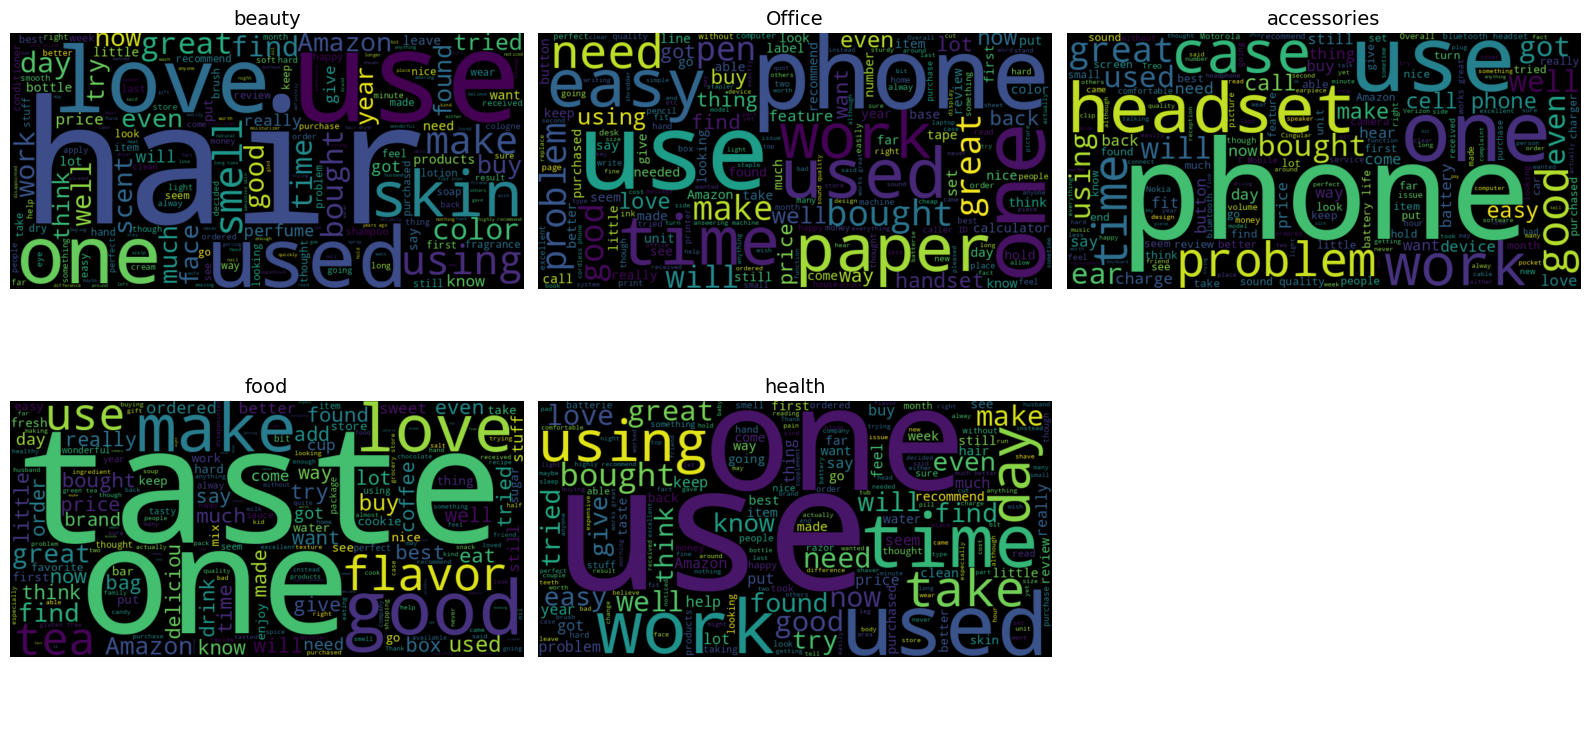

In [17]:
# Siapkan stopwords
stopwords = set(STOPWORDS)
stopwords.update(['produk', 'product'])

# Daftar kategori unik
categories = df['category'].unique()

# Tentukan ukuran plot grid
n_cols = 3
n_rows = (len(categories) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

for i, category in enumerate(categories):
    ax = axes[i]
    
    # Ambil semua komentar untuk kategori ini
    comments = df[df['category'] == category]['comment'].astype(str)
    text = " ".join(comments.tolist())

    # Buat wordcloud
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, colormap='viridis').generate(text)
    
    # Tampilkan di subplot
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(category, fontsize=14)
    ax.axis("off")

# Kosongkan axis yang tidak terpakai (jika jumlah kategori < jumlah grid slot)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [21]:
from tqdm import tqdm
import faiss
import numpy as np

# Struktur penyimpanan index dan data
faiss_indexes = {}
category_embeddings = {}
category_df = {}

print("🚀 Building FAISS indexes per category...")

for category in tqdm(df['category'].unique(), desc="🔧 Build FAISS"):
    df_cat = df[df['category'] == category].reset_index(drop=True)
    if len(df_cat) < 10:
        continue
    embeds = np.array(df_cat['SBERT_Embedding'].tolist()).astype('float32')
    faiss.normalize_L2(embeds)
    index = faiss.IndexFlatIP(embeds.shape[1])
    index.add(embeds)

    faiss_indexes[category] = index
    category_embeddings[category] = embeds
    category_df[category] = df_cat


🚀 Building FAISS indexes per category...


🔧 Build FAISS: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


In [22]:
def evaluate_faiss_per_category(df, category_embeddings, category_df, faiss_indexes, top_k=10, sample_per_category=10):
    from tqdm import tqdm

    print("🔍 Evaluating FAISS-only Hit@K, Precision@K, Recall@K per category...\n")
    
    category_results = {}

    total_hit = 0
    total_precision = 0.0
    total_recall = 0.0
    total_samples = 0

    for category in tqdm(df['category'].unique(), desc="📁 Evaluating Categories"):
        if category not in faiss_indexes:
            continue

        df_cat = category_df[category]
        embeds_cat = category_embeddings[category]
        index = faiss_indexes[category]

        if len(df_cat) < sample_per_category:
            print(f"⚠️ Skip category '{category}' (produk terlalu sedikit)")
            continue

        sample_indices = np.random.choice(len(df_cat), size=sample_per_category, replace=False)

        hits, count, precision_sum, recall_sum = 0, 0, 0.0, 0.0

        for idx in sample_indices:
            example = df_cat.iloc[idx]
            user_id = example['userID']
            user_products = df[df['userID'] == user_id]
            true_items = set(user_products['productID'])

            if not true_items:
                continue

            query_vector = embeds_cat[idx].reshape(1, -1).astype('float32')
            faiss.normalize_L2(query_vector)
            D, I = index.search(query_vector, k=top_k + 1)
            rec_indices = [i for i in I[0] if i != idx]
            rec_pids = [df_cat.iloc[i]['productID'] for i in rec_indices[:top_k]]

            relevant_retrieved = sum(pid in true_items for pid in rec_pids)

            hit = int(relevant_retrieved > 0)
            precision = relevant_retrieved / top_k
            recall = relevant_retrieved / len(true_items)
            recall = min(recall, 1.0)  # 🛑 Clamp maksimum 1.0


            hits += hit
            precision_sum += precision
            recall_sum += recall
            count += 1

        if count > 0:
            hit_rate = hits / count
            precision_avg = precision_sum / count
            recall_avg = recall_sum / count

            category_results[category] = {
                "Hit@K": hit_rate,
                "Precision@K": precision_avg,
                "Recall@K": recall_avg,
                "Evaluated": count
            }

            # Tambahkan ke total global
            total_hit += hits
            total_precision += precision_sum
            total_recall += recall_sum
            total_samples += count

            print(f"\n📂 Category: {category}")
            print(f"  ✅ Hit@{top_k}: {hit_rate:.2%}")
            print(f"  🎯 Precision@{top_k}: {precision_avg:.2%}")
            print(f"  📈 Recall@{top_k}: {recall_avg:.2%}")
            print(f"  🧪 Samples: {count}")

    # === Global result
    if total_samples > 0:
        print("\n📊 === Overall Evaluation ===")
        print(f"✅ Average Hit@{top_k}: {total_hit / total_samples:.2%}")
        print(f"🎯 Average Precision@{top_k}: {total_precision / total_samples:.2%}")
        print(f"📈 Average Recall@{top_k}: {total_recall / total_samples:.2%}")
    else:
        print("⚠️ No valid samples evaluated across categories.")

    return category_results


In [23]:
evaluate_faiss_per_category(
    df=df,
    category_embeddings=category_embeddings,
    category_df=category_df,
    faiss_indexes=faiss_indexes,
    top_k=10,
    sample_per_category=7000  # ambil 10 produk per kategori
)


🔍 Evaluating FAISS-only Hit@K, Precision@K, Recall@K per category...



📁 Evaluating Categories:  20%|██        | 1/5 [11:29<45:56, 689.15s/it]


📂 Category: beauty
  ✅ Hit@10: 91.59%
  🎯 Precision@10: 70.79%
  📈 Recall@10: 82.00%
  🧪 Samples: 7000



📁 Evaluating Categories:  40%|████      | 2/5 [21:24<31:41, 633.70s/it]


📂 Category: Office
  ✅ Hit@10: 90.99%
  🎯 Precision@10: 65.61%
  📈 Recall@10: 82.99%
  🧪 Samples: 7000



📁 Evaluating Categories:  60%|██████    | 3/5 [30:28<19:45, 592.86s/it]


📂 Category: accessories
  ✅ Hit@10: 91.60%
  🎯 Precision@10: 68.32%
  📈 Recall@10: 86.54%
  🧪 Samples: 7000



📁 Evaluating Categories:  80%|████████  | 4/5 [40:34<09:58, 598.18s/it]


📂 Category: food
  ✅ Hit@10: 91.06%
  🎯 Precision@10: 64.07%
  📈 Recall@10: 80.55%
  🧪 Samples: 7000


📁 Evaluating Categories: 100%|██████████| 5/5 [54:30<00:00, 654.06s/it]


📂 Category: health
  ✅ Hit@10: 92.67%
  🎯 Precision@10: 72.99%
  📈 Recall@10: 84.35%
  🧪 Samples: 7000

📊 === Overall Evaluation ===
✅ Average Hit@10: 91.58%
🎯 Average Precision@10: 68.36%
📈 Average Recall@10: 83.29%


{'beauty': {'Hit@K': 0.9158571428571428,
  'Precision@K': 0.7078857142857156,
  'Recall@K': 0.8200413385815728,
  'Evaluated': 7000},
 'Office': {'Hit@K': 0.9098571428571428,
  'Precision@K': 0.6561142857142852,
  'Recall@K': 0.829885764488566,
  'Evaluated': 7000},
 'accessories': {'Hit@K': 0.916,
  'Precision@K': 0.6832000000000013,
  'Recall@K': 0.8654465535488687,
  'Evaluated': 7000},
 'food': {'Hit@K': 0.9105714285714286,
  'Precision@K': 0.640714285714284,
  'Recall@K': 0.8055177483819295,
  'Evaluated': 7000},
 'health': {'Hit@K': 0.9267142857142857,
  'Precision@K': 0.7298571428571445,
  'Recall@K': 0.8434949743944234,
  'Evaluated': 7000}}

In [24]:
# === [1] Import & Load Data ===
print("➡️ Mulai tahap: # === [1] Import & Load Data ===")
import pandas as pd
import numpy as np
import random
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras import layers, Model

# Cek GPU
if tf.config.list_physical_devices('GPU'):
    print("✅ TensorFlow: GPU tersedia")
else:
    print("⚠️ TensorFlow: GPU tidak terdeteksi")

df['SBERT_Embedding'] = list(embeddings)
print("✅ Embedding selesai.")

# === [2] Generate Positive & Negative Samples ===
print("➡️ Mulai tahap: # === [2] Generate Positive & Negative Samples ===")
pos_df = df.copy()
pos_df['label'] = 1

negatives = []
all_items = set(df['productID'])
user_to_items = df.groupby('userID')['productID'].apply(set).to_dict()

# Tambahkan progress
print("🔄 Membuat negative samples...")
total_users = len(pos_df['userID'].unique())
for idx, (user_id, group) in enumerate(pos_df.groupby('userID')):
    if idx % 100 == 0:
        print(f"  ➤ Proses user ke-{idx}/{total_users}")

    interacted = user_to_items.get(user_id, set())
    negative_candidates = list(all_items - interacted)
    sampled = random.sample(negative_candidates, min(1, len(negative_candidates)))
    for item_id in sampled:
        negatives.append({
            'userID': user_id,
            'productID': item_id,
            'label': 0
        })

neg_df = pd.DataFrame(negatives)
pos_df = pos_df[['userID', 'productID', 'label']]
train_df = pd.concat([pos_df, neg_df], ignore_index=True)
print(f"✅ Total positif: {len(pos_df)}, negatif: {len(neg_df)}")

# Encode user & product
print("🔢 Meng-encode user dan product...")
user_to_idx = {u: i for i, u in enumerate(train_df['userID'].unique())}
item_to_idx = {i: j for j, i in enumerate(train_df['productID'].unique())}
train_df['user_idx'] = train_df['userID'].map(user_to_idx)
train_df['item_idx'] = train_df['productID'].map(item_to_idx)

# Final data
user_input = train_df['user_idx'].astype('int32').values
item_input = train_df['item_idx'].astype('int32').values
labels = train_df['label'].astype('float32').values
print("✅ Total interaksi:", len(train_df))

# === [3] Neural Collaborative Filtering Model ===
print("➡️ Mulai tahap: # === [3] NCF Model Building ===")
num_users = len(user_to_idx)
num_items = len(item_to_idx)
embedding_dim = 64

u_input = layers.Input(shape=(), dtype='int32', name='user')
i_input = layers.Input(shape=(), dtype='int32', name='item')

u_embedding = layers.Embedding(num_users, embedding_dim)(u_input)
i_embedding = layers.Embedding(num_items, embedding_dim)(i_input)

u_vec = layers.Flatten()(u_embedding)
i_vec = layers.Flatten()(i_embedding)

x = layers.Concatenate()([u_vec, i_vec])
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
out = layers.Dense(1, activation='sigmoid')(x)

ncf_model = Model(inputs=[u_input, i_input], outputs=out)
ncf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ncf_model.summary()
print("✅ Model siap dilatih")

# === [4] Train ===
print("➡️ Mulai tahap: # === [4] Training Model ===")
history = ncf_model.fit([user_input, item_input], labels, epochs=5, batch_size=32, validation_split=0.1, shuffle=True)
print("✅ Training selesai")

# === [5] Evaluate ===
print("➡️ Mulai tahap: # === [5] Evaluasi Model ===")
loss, acc = ncf_model.evaluate([user_input, item_input], labels)
print(f"\n✅ Akurasi akhir: {acc*100:.2f}%")


➡️ Mulai tahap: # === [1] Import & Load Data ===
✅ TensorFlow: GPU tersedia
✅ Embedding selesai.
➡️ Mulai tahap: # === [2] Generate Positive & Negative Samples ===
🔄 Membuat negative samples...
  ➤ Proses user ke-0/679746
  ➤ Proses user ke-100/679746
  ➤ Proses user ke-200/679746
  ➤ Proses user ke-300/679746
  ➤ Proses user ke-400/679746
  ➤ Proses user ke-500/679746
  ➤ Proses user ke-600/679746
  ➤ Proses user ke-700/679746
  ➤ Proses user ke-800/679746
  ➤ Proses user ke-900/679746
  ➤ Proses user ke-1000/679746
  ➤ Proses user ke-1100/679746
  ➤ Proses user ke-1200/679746
  ➤ Proses user ke-1300/679746
  ➤ Proses user ke-1400/679746
  ➤ Proses user ke-1500/679746
  ➤ Proses user ke-1600/679746
  ➤ Proses user ke-1700/679746
  ➤ Proses user ke-1800/679746
  ➤ Proses user ke-1900/679746
  ➤ Proses user ke-2000/679746
  ➤ Proses user ke-2100/679746
  ➤ Proses user ke-2200/679746
  ➤ Proses user ke-2300/679746
  ➤ Proses user ke-2400/679746
  ➤ Proses user ke-2500/679746
  ➤ Proses u

  ➤ Proses user ke-25800/679746
  ➤ Proses user ke-25900/679746
  ➤ Proses user ke-26000/679746
  ➤ Proses user ke-26100/679746
  ➤ Proses user ke-26200/679746
  ➤ Proses user ke-26300/679746
  ➤ Proses user ke-26400/679746
  ➤ Proses user ke-26500/679746
  ➤ Proses user ke-26600/679746
  ➤ Proses user ke-26700/679746
  ➤ Proses user ke-26800/679746
  ➤ Proses user ke-26900/679746
  ➤ Proses user ke-27000/679746
  ➤ Proses user ke-27100/679746
  ➤ Proses user ke-27200/679746
  ➤ Proses user ke-27300/679746
  ➤ Proses user ke-27400/679746
  ➤ Proses user ke-27500/679746
  ➤ Proses user ke-27600/679746
  ➤ Proses user ke-27700/679746
  ➤ Proses user ke-27800/679746
  ➤ Proses user ke-27900/679746
  ➤ Proses user ke-28000/679746
  ➤ Proses user ke-28100/679746
  ➤ Proses user ke-28200/679746
  ➤ Proses user ke-28300/679746
  ➤ Proses user ke-28400/679746
  ➤ Proses user ke-28500/679746
  ➤ Proses user ke-28600/679746
  ➤ Proses user ke-28700/679746
  ➤ Proses user ke-28800/679746
  ➤ Pros

  ➤ Proses user ke-52000/679746
  ➤ Proses user ke-52100/679746
  ➤ Proses user ke-52200/679746
  ➤ Proses user ke-52300/679746
  ➤ Proses user ke-52400/679746
  ➤ Proses user ke-52500/679746
  ➤ Proses user ke-52600/679746
  ➤ Proses user ke-52700/679746
  ➤ Proses user ke-52800/679746
  ➤ Proses user ke-52900/679746
  ➤ Proses user ke-53000/679746
  ➤ Proses user ke-53100/679746
  ➤ Proses user ke-53200/679746
  ➤ Proses user ke-53300/679746
  ➤ Proses user ke-53400/679746
  ➤ Proses user ke-53500/679746
  ➤ Proses user ke-53600/679746
  ➤ Proses user ke-53700/679746
  ➤ Proses user ke-53800/679746
  ➤ Proses user ke-53900/679746
  ➤ Proses user ke-54000/679746
  ➤ Proses user ke-54100/679746
  ➤ Proses user ke-54200/679746
  ➤ Proses user ke-54300/679746
  ➤ Proses user ke-54400/679746
  ➤ Proses user ke-54500/679746
  ➤ Proses user ke-54600/679746
  ➤ Proses user ke-54700/679746
  ➤ Proses user ke-54800/679746
  ➤ Proses user ke-54900/679746
  ➤ Proses user ke-55000/679746
  ➤ Pros

  ➤ Proses user ke-78600/679746
  ➤ Proses user ke-78700/679746
  ➤ Proses user ke-78800/679746
  ➤ Proses user ke-78900/679746
  ➤ Proses user ke-79000/679746
  ➤ Proses user ke-79100/679746
  ➤ Proses user ke-79200/679746
  ➤ Proses user ke-79300/679746
  ➤ Proses user ke-79400/679746
  ➤ Proses user ke-79500/679746
  ➤ Proses user ke-79600/679746
  ➤ Proses user ke-79700/679746
  ➤ Proses user ke-79800/679746
  ➤ Proses user ke-79900/679746
  ➤ Proses user ke-80000/679746
  ➤ Proses user ke-80100/679746
  ➤ Proses user ke-80200/679746
  ➤ Proses user ke-80300/679746
  ➤ Proses user ke-80400/679746
  ➤ Proses user ke-80500/679746
  ➤ Proses user ke-80600/679746
  ➤ Proses user ke-80700/679746
  ➤ Proses user ke-80800/679746
  ➤ Proses user ke-80900/679746
  ➤ Proses user ke-81000/679746
  ➤ Proses user ke-81100/679746
  ➤ Proses user ke-81200/679746
  ➤ Proses user ke-81300/679746
  ➤ Proses user ke-81400/679746
  ➤ Proses user ke-81500/679746
  ➤ Proses user ke-81600/679746
  ➤ Pros

  ➤ Proses user ke-105100/679746
  ➤ Proses user ke-105200/679746
  ➤ Proses user ke-105300/679746
  ➤ Proses user ke-105400/679746
  ➤ Proses user ke-105500/679746
  ➤ Proses user ke-105600/679746
  ➤ Proses user ke-105700/679746
  ➤ Proses user ke-105800/679746
  ➤ Proses user ke-105900/679746
  ➤ Proses user ke-106000/679746
  ➤ Proses user ke-106100/679746
  ➤ Proses user ke-106200/679746
  ➤ Proses user ke-106300/679746
  ➤ Proses user ke-106400/679746
  ➤ Proses user ke-106500/679746
  ➤ Proses user ke-106600/679746
  ➤ Proses user ke-106700/679746
  ➤ Proses user ke-106800/679746
  ➤ Proses user ke-106900/679746
  ➤ Proses user ke-107000/679746
  ➤ Proses user ke-107100/679746
  ➤ Proses user ke-107200/679746
  ➤ Proses user ke-107300/679746
  ➤ Proses user ke-107400/679746
  ➤ Proses user ke-107500/679746
  ➤ Proses user ke-107600/679746
  ➤ Proses user ke-107700/679746
  ➤ Proses user ke-107800/679746
  ➤ Proses user ke-107900/679746
  ➤ Proses user ke-108000/679746
  ➤ Proses

  ➤ Proses user ke-130000/679746
  ➤ Proses user ke-130100/679746
  ➤ Proses user ke-130200/679746
  ➤ Proses user ke-130300/679746
  ➤ Proses user ke-130400/679746
  ➤ Proses user ke-130500/679746
  ➤ Proses user ke-130600/679746
  ➤ Proses user ke-130700/679746
  ➤ Proses user ke-130800/679746
  ➤ Proses user ke-130900/679746
  ➤ Proses user ke-131000/679746
  ➤ Proses user ke-131100/679746
  ➤ Proses user ke-131200/679746
  ➤ Proses user ke-131300/679746
  ➤ Proses user ke-131400/679746
  ➤ Proses user ke-131500/679746
  ➤ Proses user ke-131600/679746
  ➤ Proses user ke-131700/679746
  ➤ Proses user ke-131800/679746
  ➤ Proses user ke-131900/679746
  ➤ Proses user ke-132000/679746
  ➤ Proses user ke-132100/679746
  ➤ Proses user ke-132200/679746
  ➤ Proses user ke-132300/679746
  ➤ Proses user ke-132400/679746
  ➤ Proses user ke-132500/679746
  ➤ Proses user ke-132600/679746
  ➤ Proses user ke-132700/679746
  ➤ Proses user ke-132800/679746
  ➤ Proses user ke-132900/679746
  ➤ Proses

  ➤ Proses user ke-155600/679746
  ➤ Proses user ke-155700/679746
  ➤ Proses user ke-155800/679746
  ➤ Proses user ke-155900/679746
  ➤ Proses user ke-156000/679746
  ➤ Proses user ke-156100/679746
  ➤ Proses user ke-156200/679746
  ➤ Proses user ke-156300/679746
  ➤ Proses user ke-156400/679746
  ➤ Proses user ke-156500/679746
  ➤ Proses user ke-156600/679746
  ➤ Proses user ke-156700/679746
  ➤ Proses user ke-156800/679746
  ➤ Proses user ke-156900/679746
  ➤ Proses user ke-157000/679746
  ➤ Proses user ke-157100/679746
  ➤ Proses user ke-157200/679746
  ➤ Proses user ke-157300/679746
  ➤ Proses user ke-157400/679746
  ➤ Proses user ke-157500/679746
  ➤ Proses user ke-157600/679746
  ➤ Proses user ke-157700/679746
  ➤ Proses user ke-157800/679746
  ➤ Proses user ke-157900/679746
  ➤ Proses user ke-158000/679746
  ➤ Proses user ke-158100/679746
  ➤ Proses user ke-158200/679746
  ➤ Proses user ke-158300/679746
  ➤ Proses user ke-158400/679746
  ➤ Proses user ke-158500/679746
  ➤ Proses

  ➤ Proses user ke-180900/679746
  ➤ Proses user ke-181000/679746
  ➤ Proses user ke-181100/679746
  ➤ Proses user ke-181200/679746
  ➤ Proses user ke-181300/679746
  ➤ Proses user ke-181400/679746
  ➤ Proses user ke-181500/679746
  ➤ Proses user ke-181600/679746
  ➤ Proses user ke-181700/679746
  ➤ Proses user ke-181800/679746
  ➤ Proses user ke-181900/679746
  ➤ Proses user ke-182000/679746
  ➤ Proses user ke-182100/679746
  ➤ Proses user ke-182200/679746
  ➤ Proses user ke-182300/679746
  ➤ Proses user ke-182400/679746
  ➤ Proses user ke-182500/679746
  ➤ Proses user ke-182600/679746
  ➤ Proses user ke-182700/679746
  ➤ Proses user ke-182800/679746
  ➤ Proses user ke-182900/679746
  ➤ Proses user ke-183000/679746
  ➤ Proses user ke-183100/679746
  ➤ Proses user ke-183200/679746
  ➤ Proses user ke-183300/679746
  ➤ Proses user ke-183400/679746
  ➤ Proses user ke-183500/679746
  ➤ Proses user ke-183600/679746
  ➤ Proses user ke-183700/679746
  ➤ Proses user ke-183800/679746
  ➤ Proses

  ➤ Proses user ke-206200/679746
  ➤ Proses user ke-206300/679746
  ➤ Proses user ke-206400/679746
  ➤ Proses user ke-206500/679746
  ➤ Proses user ke-206600/679746
  ➤ Proses user ke-206700/679746
  ➤ Proses user ke-206800/679746
  ➤ Proses user ke-206900/679746
  ➤ Proses user ke-207000/679746
  ➤ Proses user ke-207100/679746
  ➤ Proses user ke-207200/679746
  ➤ Proses user ke-207300/679746
  ➤ Proses user ke-207400/679746
  ➤ Proses user ke-207500/679746
  ➤ Proses user ke-207600/679746
  ➤ Proses user ke-207700/679746
  ➤ Proses user ke-207800/679746
  ➤ Proses user ke-207900/679746
  ➤ Proses user ke-208000/679746
  ➤ Proses user ke-208100/679746
  ➤ Proses user ke-208200/679746
  ➤ Proses user ke-208300/679746
  ➤ Proses user ke-208400/679746
  ➤ Proses user ke-208500/679746
  ➤ Proses user ke-208600/679746
  ➤ Proses user ke-208700/679746
  ➤ Proses user ke-208800/679746
  ➤ Proses user ke-208900/679746
  ➤ Proses user ke-209000/679746
  ➤ Proses user ke-209100/679746
  ➤ Proses

  ➤ Proses user ke-232300/679746
  ➤ Proses user ke-232400/679746
  ➤ Proses user ke-232500/679746
  ➤ Proses user ke-232600/679746
  ➤ Proses user ke-232700/679746
  ➤ Proses user ke-232800/679746
  ➤ Proses user ke-232900/679746
  ➤ Proses user ke-233000/679746
  ➤ Proses user ke-233100/679746
  ➤ Proses user ke-233200/679746
  ➤ Proses user ke-233300/679746
  ➤ Proses user ke-233400/679746
  ➤ Proses user ke-233500/679746
  ➤ Proses user ke-233600/679746
  ➤ Proses user ke-233700/679746
  ➤ Proses user ke-233800/679746
  ➤ Proses user ke-233900/679746
  ➤ Proses user ke-234000/679746
  ➤ Proses user ke-234100/679746
  ➤ Proses user ke-234200/679746
  ➤ Proses user ke-234300/679746
  ➤ Proses user ke-234400/679746
  ➤ Proses user ke-234500/679746
  ➤ Proses user ke-234600/679746
  ➤ Proses user ke-234700/679746
  ➤ Proses user ke-234800/679746
  ➤ Proses user ke-234900/679746
  ➤ Proses user ke-235000/679746
  ➤ Proses user ke-235100/679746
  ➤ Proses user ke-235200/679746
  ➤ Proses

  ➤ Proses user ke-257900/679746
  ➤ Proses user ke-258000/679746
  ➤ Proses user ke-258100/679746
  ➤ Proses user ke-258200/679746
  ➤ Proses user ke-258300/679746
  ➤ Proses user ke-258400/679746
  ➤ Proses user ke-258500/679746
  ➤ Proses user ke-258600/679746
  ➤ Proses user ke-258700/679746
  ➤ Proses user ke-258800/679746
  ➤ Proses user ke-258900/679746
  ➤ Proses user ke-259000/679746
  ➤ Proses user ke-259100/679746
  ➤ Proses user ke-259200/679746
  ➤ Proses user ke-259300/679746
  ➤ Proses user ke-259400/679746
  ➤ Proses user ke-259500/679746
  ➤ Proses user ke-259600/679746
  ➤ Proses user ke-259700/679746
  ➤ Proses user ke-259800/679746
  ➤ Proses user ke-259900/679746
  ➤ Proses user ke-260000/679746
  ➤ Proses user ke-260100/679746
  ➤ Proses user ke-260200/679746
  ➤ Proses user ke-260300/679746
  ➤ Proses user ke-260400/679746
  ➤ Proses user ke-260500/679746
  ➤ Proses user ke-260600/679746
  ➤ Proses user ke-260700/679746
  ➤ Proses user ke-260800/679746
  ➤ Proses

  ➤ Proses user ke-283500/679746
  ➤ Proses user ke-283600/679746
  ➤ Proses user ke-283700/679746
  ➤ Proses user ke-283800/679746
  ➤ Proses user ke-283900/679746
  ➤ Proses user ke-284000/679746
  ➤ Proses user ke-284100/679746
  ➤ Proses user ke-284200/679746
  ➤ Proses user ke-284300/679746
  ➤ Proses user ke-284400/679746
  ➤ Proses user ke-284500/679746
  ➤ Proses user ke-284600/679746
  ➤ Proses user ke-284700/679746
  ➤ Proses user ke-284800/679746
  ➤ Proses user ke-284900/679746
  ➤ Proses user ke-285000/679746
  ➤ Proses user ke-285100/679746
  ➤ Proses user ke-285200/679746
  ➤ Proses user ke-285300/679746
  ➤ Proses user ke-285400/679746
  ➤ Proses user ke-285500/679746
  ➤ Proses user ke-285600/679746
  ➤ Proses user ke-285700/679746
  ➤ Proses user ke-285800/679746
  ➤ Proses user ke-285900/679746
  ➤ Proses user ke-286000/679746
  ➤ Proses user ke-286100/679746
  ➤ Proses user ke-286200/679746
  ➤ Proses user ke-286300/679746
  ➤ Proses user ke-286400/679746
  ➤ Proses

  ➤ Proses user ke-309600/679746
  ➤ Proses user ke-309700/679746
  ➤ Proses user ke-309800/679746
  ➤ Proses user ke-309900/679746
  ➤ Proses user ke-310000/679746
  ➤ Proses user ke-310100/679746
  ➤ Proses user ke-310200/679746
  ➤ Proses user ke-310300/679746
  ➤ Proses user ke-310400/679746
  ➤ Proses user ke-310500/679746
  ➤ Proses user ke-310600/679746
  ➤ Proses user ke-310700/679746
  ➤ Proses user ke-310800/679746
  ➤ Proses user ke-310900/679746
  ➤ Proses user ke-311000/679746
  ➤ Proses user ke-311100/679746
  ➤ Proses user ke-311200/679746
  ➤ Proses user ke-311300/679746
  ➤ Proses user ke-311400/679746
  ➤ Proses user ke-311500/679746
  ➤ Proses user ke-311600/679746
  ➤ Proses user ke-311700/679746
  ➤ Proses user ke-311800/679746
  ➤ Proses user ke-311900/679746
  ➤ Proses user ke-312000/679746
  ➤ Proses user ke-312100/679746
  ➤ Proses user ke-312200/679746
  ➤ Proses user ke-312300/679746
  ➤ Proses user ke-312400/679746
  ➤ Proses user ke-312500/679746
  ➤ Proses

  ➤ Proses user ke-334600/679746
  ➤ Proses user ke-334700/679746
  ➤ Proses user ke-334800/679746
  ➤ Proses user ke-334900/679746
  ➤ Proses user ke-335000/679746
  ➤ Proses user ke-335100/679746
  ➤ Proses user ke-335200/679746
  ➤ Proses user ke-335300/679746
  ➤ Proses user ke-335400/679746
  ➤ Proses user ke-335500/679746
  ➤ Proses user ke-335600/679746
  ➤ Proses user ke-335700/679746
  ➤ Proses user ke-335800/679746
  ➤ Proses user ke-335900/679746
  ➤ Proses user ke-336000/679746
  ➤ Proses user ke-336100/679746
  ➤ Proses user ke-336200/679746
  ➤ Proses user ke-336300/679746
  ➤ Proses user ke-336400/679746
  ➤ Proses user ke-336500/679746
  ➤ Proses user ke-336600/679746
  ➤ Proses user ke-336700/679746
  ➤ Proses user ke-336800/679746
  ➤ Proses user ke-336900/679746
  ➤ Proses user ke-337000/679746
  ➤ Proses user ke-337100/679746
  ➤ Proses user ke-337200/679746
  ➤ Proses user ke-337300/679746
  ➤ Proses user ke-337400/679746
  ➤ Proses user ke-337500/679746
  ➤ Proses

  ➤ Proses user ke-359700/679746
  ➤ Proses user ke-359800/679746
  ➤ Proses user ke-359900/679746
  ➤ Proses user ke-360000/679746
  ➤ Proses user ke-360100/679746
  ➤ Proses user ke-360200/679746
  ➤ Proses user ke-360300/679746
  ➤ Proses user ke-360400/679746
  ➤ Proses user ke-360500/679746
  ➤ Proses user ke-360600/679746
  ➤ Proses user ke-360700/679746
  ➤ Proses user ke-360800/679746
  ➤ Proses user ke-360900/679746
  ➤ Proses user ke-361000/679746
  ➤ Proses user ke-361100/679746
  ➤ Proses user ke-361200/679746
  ➤ Proses user ke-361300/679746
  ➤ Proses user ke-361400/679746
  ➤ Proses user ke-361500/679746
  ➤ Proses user ke-361600/679746
  ➤ Proses user ke-361700/679746
  ➤ Proses user ke-361800/679746
  ➤ Proses user ke-361900/679746
  ➤ Proses user ke-362000/679746
  ➤ Proses user ke-362100/679746
  ➤ Proses user ke-362200/679746
  ➤ Proses user ke-362300/679746
  ➤ Proses user ke-362400/679746
  ➤ Proses user ke-362500/679746
  ➤ Proses user ke-362600/679746
  ➤ Proses

  ➤ Proses user ke-385000/679746
  ➤ Proses user ke-385100/679746
  ➤ Proses user ke-385200/679746
  ➤ Proses user ke-385300/679746
  ➤ Proses user ke-385400/679746
  ➤ Proses user ke-385500/679746
  ➤ Proses user ke-385600/679746
  ➤ Proses user ke-385700/679746
  ➤ Proses user ke-385800/679746
  ➤ Proses user ke-385900/679746
  ➤ Proses user ke-386000/679746
  ➤ Proses user ke-386100/679746
  ➤ Proses user ke-386200/679746
  ➤ Proses user ke-386300/679746
  ➤ Proses user ke-386400/679746
  ➤ Proses user ke-386500/679746
  ➤ Proses user ke-386600/679746
  ➤ Proses user ke-386700/679746
  ➤ Proses user ke-386800/679746
  ➤ Proses user ke-386900/679746
  ➤ Proses user ke-387000/679746
  ➤ Proses user ke-387100/679746
  ➤ Proses user ke-387200/679746
  ➤ Proses user ke-387300/679746
  ➤ Proses user ke-387400/679746
  ➤ Proses user ke-387500/679746
  ➤ Proses user ke-387600/679746
  ➤ Proses user ke-387700/679746
  ➤ Proses user ke-387800/679746
  ➤ Proses user ke-387900/679746
  ➤ Proses

  ➤ Proses user ke-410900/679746
  ➤ Proses user ke-411000/679746
  ➤ Proses user ke-411100/679746
  ➤ Proses user ke-411200/679746
  ➤ Proses user ke-411300/679746
  ➤ Proses user ke-411400/679746
  ➤ Proses user ke-411500/679746
  ➤ Proses user ke-411600/679746
  ➤ Proses user ke-411700/679746
  ➤ Proses user ke-411800/679746
  ➤ Proses user ke-411900/679746
  ➤ Proses user ke-412000/679746
  ➤ Proses user ke-412100/679746
  ➤ Proses user ke-412200/679746
  ➤ Proses user ke-412300/679746
  ➤ Proses user ke-412400/679746
  ➤ Proses user ke-412500/679746
  ➤ Proses user ke-412600/679746
  ➤ Proses user ke-412700/679746
  ➤ Proses user ke-412800/679746
  ➤ Proses user ke-412900/679746
  ➤ Proses user ke-413000/679746
  ➤ Proses user ke-413100/679746
  ➤ Proses user ke-413200/679746
  ➤ Proses user ke-413300/679746
  ➤ Proses user ke-413400/679746
  ➤ Proses user ke-413500/679746
  ➤ Proses user ke-413600/679746
  ➤ Proses user ke-413700/679746
  ➤ Proses user ke-413800/679746
  ➤ Proses

  ➤ Proses user ke-436700/679746
  ➤ Proses user ke-436800/679746
  ➤ Proses user ke-436900/679746
  ➤ Proses user ke-437000/679746
  ➤ Proses user ke-437100/679746
  ➤ Proses user ke-437200/679746
  ➤ Proses user ke-437300/679746
  ➤ Proses user ke-437400/679746
  ➤ Proses user ke-437500/679746
  ➤ Proses user ke-437600/679746
  ➤ Proses user ke-437700/679746
  ➤ Proses user ke-437800/679746
  ➤ Proses user ke-437900/679746
  ➤ Proses user ke-438000/679746
  ➤ Proses user ke-438100/679746
  ➤ Proses user ke-438200/679746
  ➤ Proses user ke-438300/679746
  ➤ Proses user ke-438400/679746
  ➤ Proses user ke-438500/679746
  ➤ Proses user ke-438600/679746
  ➤ Proses user ke-438700/679746
  ➤ Proses user ke-438800/679746
  ➤ Proses user ke-438900/679746
  ➤ Proses user ke-439000/679746
  ➤ Proses user ke-439100/679746
  ➤ Proses user ke-439200/679746
  ➤ Proses user ke-439300/679746
  ➤ Proses user ke-439400/679746
  ➤ Proses user ke-439500/679746
  ➤ Proses user ke-439600/679746
  ➤ Proses

  ➤ Proses user ke-462000/679746
  ➤ Proses user ke-462100/679746
  ➤ Proses user ke-462200/679746
  ➤ Proses user ke-462300/679746
  ➤ Proses user ke-462400/679746
  ➤ Proses user ke-462500/679746
  ➤ Proses user ke-462600/679746
  ➤ Proses user ke-462700/679746
  ➤ Proses user ke-462800/679746
  ➤ Proses user ke-462900/679746
  ➤ Proses user ke-463000/679746
  ➤ Proses user ke-463100/679746
  ➤ Proses user ke-463200/679746
  ➤ Proses user ke-463300/679746
  ➤ Proses user ke-463400/679746
  ➤ Proses user ke-463500/679746
  ➤ Proses user ke-463600/679746
  ➤ Proses user ke-463700/679746
  ➤ Proses user ke-463800/679746
  ➤ Proses user ke-463900/679746
  ➤ Proses user ke-464000/679746
  ➤ Proses user ke-464100/679746
  ➤ Proses user ke-464200/679746
  ➤ Proses user ke-464300/679746
  ➤ Proses user ke-464400/679746
  ➤ Proses user ke-464500/679746
  ➤ Proses user ke-464600/679746
  ➤ Proses user ke-464700/679746
  ➤ Proses user ke-464800/679746
  ➤ Proses user ke-464900/679746
  ➤ Proses

  ➤ Proses user ke-488300/679746
  ➤ Proses user ke-488400/679746
  ➤ Proses user ke-488500/679746
  ➤ Proses user ke-488600/679746
  ➤ Proses user ke-488700/679746
  ➤ Proses user ke-488800/679746
  ➤ Proses user ke-488900/679746
  ➤ Proses user ke-489000/679746
  ➤ Proses user ke-489100/679746
  ➤ Proses user ke-489200/679746
  ➤ Proses user ke-489300/679746
  ➤ Proses user ke-489400/679746
  ➤ Proses user ke-489500/679746
  ➤ Proses user ke-489600/679746
  ➤ Proses user ke-489700/679746
  ➤ Proses user ke-489800/679746
  ➤ Proses user ke-489900/679746
  ➤ Proses user ke-490000/679746
  ➤ Proses user ke-490100/679746
  ➤ Proses user ke-490200/679746
  ➤ Proses user ke-490300/679746
  ➤ Proses user ke-490400/679746
  ➤ Proses user ke-490500/679746
  ➤ Proses user ke-490600/679746
  ➤ Proses user ke-490700/679746
  ➤ Proses user ke-490800/679746
  ➤ Proses user ke-490900/679746
  ➤ Proses user ke-491000/679746
  ➤ Proses user ke-491100/679746
  ➤ Proses user ke-491200/679746
  ➤ Proses

  ➤ Proses user ke-513800/679746
  ➤ Proses user ke-513900/679746
  ➤ Proses user ke-514000/679746
  ➤ Proses user ke-514100/679746
  ➤ Proses user ke-514200/679746
  ➤ Proses user ke-514300/679746
  ➤ Proses user ke-514400/679746
  ➤ Proses user ke-514500/679746
  ➤ Proses user ke-514600/679746
  ➤ Proses user ke-514700/679746
  ➤ Proses user ke-514800/679746
  ➤ Proses user ke-514900/679746
  ➤ Proses user ke-515000/679746
  ➤ Proses user ke-515100/679746
  ➤ Proses user ke-515200/679746
  ➤ Proses user ke-515300/679746
  ➤ Proses user ke-515400/679746
  ➤ Proses user ke-515500/679746
  ➤ Proses user ke-515600/679746
  ➤ Proses user ke-515700/679746
  ➤ Proses user ke-515800/679746
  ➤ Proses user ke-515900/679746
  ➤ Proses user ke-516000/679746
  ➤ Proses user ke-516100/679746
  ➤ Proses user ke-516200/679746
  ➤ Proses user ke-516300/679746
  ➤ Proses user ke-516400/679746
  ➤ Proses user ke-516500/679746
  ➤ Proses user ke-516600/679746
  ➤ Proses user ke-516700/679746
  ➤ Proses

  ➤ Proses user ke-539500/679746
  ➤ Proses user ke-539600/679746
  ➤ Proses user ke-539700/679746
  ➤ Proses user ke-539800/679746
  ➤ Proses user ke-539900/679746
  ➤ Proses user ke-540000/679746
  ➤ Proses user ke-540100/679746
  ➤ Proses user ke-540200/679746
  ➤ Proses user ke-540300/679746
  ➤ Proses user ke-540400/679746
  ➤ Proses user ke-540500/679746
  ➤ Proses user ke-540600/679746
  ➤ Proses user ke-540700/679746
  ➤ Proses user ke-540800/679746
  ➤ Proses user ke-540900/679746
  ➤ Proses user ke-541000/679746
  ➤ Proses user ke-541100/679746
  ➤ Proses user ke-541200/679746
  ➤ Proses user ke-541300/679746
  ➤ Proses user ke-541400/679746
  ➤ Proses user ke-541500/679746
  ➤ Proses user ke-541600/679746
  ➤ Proses user ke-541700/679746
  ➤ Proses user ke-541800/679746
  ➤ Proses user ke-541900/679746
  ➤ Proses user ke-542000/679746
  ➤ Proses user ke-542100/679746
  ➤ Proses user ke-542200/679746
  ➤ Proses user ke-542300/679746
  ➤ Proses user ke-542400/679746
  ➤ Proses

  ➤ Proses user ke-564500/679746
  ➤ Proses user ke-564600/679746
  ➤ Proses user ke-564700/679746
  ➤ Proses user ke-564800/679746
  ➤ Proses user ke-564900/679746
  ➤ Proses user ke-565000/679746
  ➤ Proses user ke-565100/679746
  ➤ Proses user ke-565200/679746
  ➤ Proses user ke-565300/679746
  ➤ Proses user ke-565400/679746
  ➤ Proses user ke-565500/679746
  ➤ Proses user ke-565600/679746
  ➤ Proses user ke-565700/679746
  ➤ Proses user ke-565800/679746
  ➤ Proses user ke-565900/679746
  ➤ Proses user ke-566000/679746
  ➤ Proses user ke-566100/679746
  ➤ Proses user ke-566200/679746
  ➤ Proses user ke-566300/679746
  ➤ Proses user ke-566400/679746
  ➤ Proses user ke-566500/679746
  ➤ Proses user ke-566600/679746
  ➤ Proses user ke-566700/679746
  ➤ Proses user ke-566800/679746
  ➤ Proses user ke-566900/679746
  ➤ Proses user ke-567000/679746
  ➤ Proses user ke-567100/679746
  ➤ Proses user ke-567200/679746
  ➤ Proses user ke-567300/679746
  ➤ Proses user ke-567400/679746
  ➤ Proses

  ➤ Proses user ke-589500/679746
  ➤ Proses user ke-589600/679746
  ➤ Proses user ke-589700/679746
  ➤ Proses user ke-589800/679746
  ➤ Proses user ke-589900/679746
  ➤ Proses user ke-590000/679746
  ➤ Proses user ke-590100/679746
  ➤ Proses user ke-590200/679746
  ➤ Proses user ke-590300/679746
  ➤ Proses user ke-590400/679746
  ➤ Proses user ke-590500/679746
  ➤ Proses user ke-590600/679746
  ➤ Proses user ke-590700/679746
  ➤ Proses user ke-590800/679746
  ➤ Proses user ke-590900/679746
  ➤ Proses user ke-591000/679746
  ➤ Proses user ke-591100/679746
  ➤ Proses user ke-591200/679746
  ➤ Proses user ke-591300/679746
  ➤ Proses user ke-591400/679746
  ➤ Proses user ke-591500/679746
  ➤ Proses user ke-591600/679746
  ➤ Proses user ke-591700/679746
  ➤ Proses user ke-591800/679746
  ➤ Proses user ke-591900/679746
  ➤ Proses user ke-592000/679746
  ➤ Proses user ke-592100/679746
  ➤ Proses user ke-592200/679746
  ➤ Proses user ke-592300/679746
  ➤ Proses user ke-592400/679746
  ➤ Proses

  ➤ Proses user ke-614400/679746
  ➤ Proses user ke-614500/679746
  ➤ Proses user ke-614600/679746
  ➤ Proses user ke-614700/679746
  ➤ Proses user ke-614800/679746
  ➤ Proses user ke-614900/679746
  ➤ Proses user ke-615000/679746
  ➤ Proses user ke-615100/679746
  ➤ Proses user ke-615200/679746
  ➤ Proses user ke-615300/679746
  ➤ Proses user ke-615400/679746
  ➤ Proses user ke-615500/679746
  ➤ Proses user ke-615600/679746
  ➤ Proses user ke-615700/679746
  ➤ Proses user ke-615800/679746
  ➤ Proses user ke-615900/679746
  ➤ Proses user ke-616000/679746
  ➤ Proses user ke-616100/679746
  ➤ Proses user ke-616200/679746
  ➤ Proses user ke-616300/679746
  ➤ Proses user ke-616400/679746
  ➤ Proses user ke-616500/679746
  ➤ Proses user ke-616600/679746
  ➤ Proses user ke-616700/679746
  ➤ Proses user ke-616800/679746
  ➤ Proses user ke-616900/679746
  ➤ Proses user ke-617000/679746
  ➤ Proses user ke-617100/679746
  ➤ Proses user ke-617200/679746
  ➤ Proses user ke-617300/679746
  ➤ Proses

  ➤ Proses user ke-639900/679746
  ➤ Proses user ke-640000/679746
  ➤ Proses user ke-640100/679746
  ➤ Proses user ke-640200/679746
  ➤ Proses user ke-640300/679746
  ➤ Proses user ke-640400/679746
  ➤ Proses user ke-640500/679746
  ➤ Proses user ke-640600/679746
  ➤ Proses user ke-640700/679746
  ➤ Proses user ke-640800/679746
  ➤ Proses user ke-640900/679746
  ➤ Proses user ke-641000/679746
  ➤ Proses user ke-641100/679746
  ➤ Proses user ke-641200/679746
  ➤ Proses user ke-641300/679746
  ➤ Proses user ke-641400/679746
  ➤ Proses user ke-641500/679746
  ➤ Proses user ke-641600/679746
  ➤ Proses user ke-641700/679746
  ➤ Proses user ke-641800/679746
  ➤ Proses user ke-641900/679746
  ➤ Proses user ke-642000/679746
  ➤ Proses user ke-642100/679746
  ➤ Proses user ke-642200/679746
  ➤ Proses user ke-642300/679746
  ➤ Proses user ke-642400/679746
  ➤ Proses user ke-642500/679746
  ➤ Proses user ke-642600/679746
  ➤ Proses user ke-642700/679746
  ➤ Proses user ke-642800/679746
  ➤ Proses

  ➤ Proses user ke-665100/679746
  ➤ Proses user ke-665200/679746
  ➤ Proses user ke-665300/679746
  ➤ Proses user ke-665400/679746
  ➤ Proses user ke-665500/679746
  ➤ Proses user ke-665600/679746
  ➤ Proses user ke-665700/679746
  ➤ Proses user ke-665800/679746
  ➤ Proses user ke-665900/679746
  ➤ Proses user ke-666000/679746
  ➤ Proses user ke-666100/679746
  ➤ Proses user ke-666200/679746
  ➤ Proses user ke-666300/679746
  ➤ Proses user ke-666400/679746
  ➤ Proses user ke-666500/679746
  ➤ Proses user ke-666600/679746
  ➤ Proses user ke-666700/679746
  ➤ Proses user ke-666800/679746
  ➤ Proses user ke-666900/679746
  ➤ Proses user ke-667000/679746
  ➤ Proses user ke-667100/679746
  ➤ Proses user ke-667200/679746
  ➤ Proses user ke-667300/679746
  ➤ Proses user ke-667400/679746
  ➤ Proses user ke-667500/679746
  ➤ Proses user ke-667600/679746
  ➤ Proses user ke-667700/679746
  ➤ Proses user ke-667800/679746
  ➤ Proses user ke-667900/679746
  ➤ Proses user ke-668000/679746
  ➤ Proses

2025-05-16 15:08:58.549428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13425 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 SUPER, pci bus id: 0000:73:00.0, compute capability: 8.9


✅ Model siap dilatih
➡️ Mulai tahap: # === [4] Training Model ===
Epoch 1/5


2025-05-16 15:09:00.627792: I external/local_xla/xla/service/service.cc:168] XLA service 0x737472adb420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-16 15:09:00.627820: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2025-05-16 15:09:00.634142: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-16 15:09:00.657714: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
I0000 00:00:1747408140.772796     953 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48669/48669 [==============================] - 559s 11ms/step - loss: 0.4363 - accuracy: 0.7852 - val_loss: 0.6500 - val_accuracy: 0.7443
Epoch 2/5
48669/48669 [==============================] - 560s 12ms/step - loss: 0.3126 - accuracy: 0.8615 - val_loss: 0.6038 - val_accuracy: 0.7240
Epoch 3/5
48669/48669 [==============================] - 558s 11ms/step - loss: 0.1386 - accuracy: 0.9464 - val_loss: 0.7874 - val_accuracy: 0.6782
Epoch 4/5
48669/48669 [==============================] - 557s 11ms/step - loss: 0.0470 - accuracy: 0.9833 - val_loss: 0.9967 - val_accuracy: 0.6736
Epoch 5/5
48669/48669 [==============================] - 558s 11ms/step - loss: 0.0190 - accuracy: 0.9934 - val_loss: 1.2401 - val_accuracy: 0.6597
✅ Training selesai
➡️ Mulai tahap: # === [5] Evaluasi Model ===
54076/54076 [==============================] - 251s 5ms/step - loss: 0.1307 - accuracy: 0.9637

✅ Akurasi akhir: 96.37%


In [34]:
import torch
import tensorflow as tf

print("=== 🔍 PyTorch Check ===")
print("Versi PyTorch:", torch.__version__)
print("CUDA tersedia:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("🖥️ PyTorch GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ PyTorch tidak mendeteksi GPU")

print("\n=== 🔍 TensorFlow Check ===")
print("Versi TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPU tersedia:", len(gpus) > 0)

if gpus:
    for i, gpu in enumerate(gpus):
        print(f"🖥️ TensorFlow GPU {i}: {gpu.name}")
else:
    print("⚠️ TensorFlow tidak mendeteksi GPU")


=== 🔍 PyTorch Check ===
Versi PyTorch: 2.5.1+cu121
CUDA tersedia: True
🖥️ PyTorch GPU: NVIDIA GeForce RTX 4080 SUPER

=== 🔍 TensorFlow Check ===
Versi TensorFlow: 2.15.0
GPU tersedia: True
🖥️ TensorFlow GPU 0: /physical_device:GPU:0


In [42]:
def evaluate_hybrid_hit_rate(user_to_idx, item_to_idx, idx_to_user, df, ncf_model, faiss_indexes, category_embeddings, category_df, k=5):
    from tqdm import tqdm
    import numpy as np

    total_hits = 0
    total_users_evaluated = 0
    total_precision = 0.0
    total_recall = 0.0

    print("🔍 Evaluating hybrid recommendations...")
    for test_user_idx in tqdm(list(user_to_idx.values())[:50000], desc="📊 Evaluasi Hybrid"):
        user_id_test = idx_to_user[test_user_idx]
        user_products = df[df['userID'] == user_id_test]
        true_items = set(user_products['productID'])

        if len(user_products) == 0 or len(true_items) == 0:
            continue

        # Ambil kategori dominan
        top_category = user_products['category'].value_counts().idxmax()
        if top_category not in faiss_indexes:
            continue

        index = faiss_indexes[top_category]
        embeds_cat = category_embeddings[top_category]
        df_cat = category_df[top_category]

        # Buat vektor user (rata-rata embedding dari produk yang user lihat)
        embed_user = np.array(user_products['SBERT_Embedding'].tolist())
        user_vector = np.mean(embed_user, axis=0).reshape(1, -1).astype('float32')
        faiss.normalize_L2(user_vector)

        # Ambil kandidat dari FAISS
        D, I = index.search(user_vector, k=10)
        candidate_idx = list(set(I[0]))

        candidate_pids = [df_cat.iloc[i]['productID'] for i in candidate_idx if df_cat.iloc[i]['productID'] in item_to_idx]
        if not candidate_pids:
            continue

        # Prediksi dengan NCF
        user_tensor = np.array([test_user_idx] * len(candidate_pids))
        item_tensor = np.array([item_to_idx[pid] for pid in candidate_pids])
        pred = ncf_model.predict([user_tensor, item_tensor], verbose=0)

        # Ambil top-K hasil
        top_k_idx = np.argsort(pred.flatten())[::-1][:k]
        top_k_items = [candidate_pids[i] for i in top_k_idx]

        # Evaluasi
        relevant_retrieved = sum(pid in true_items for pid in top_k_items)
        hit = int(relevant_retrieved > 0)
        precision = relevant_retrieved / k
        recall = min(relevant_retrieved / len(true_items), 1.0)

        total_hits += hit
        total_precision += precision
        total_recall += recall
        total_users_evaluated += 1

    if total_users_evaluated > 0:
        print("\n📊 === Hybrid Evaluation Results ===")
        print(f"✅ Hit@{k}: {total_hits / total_users_evaluated:.2%}")
        print(f"🎯 Precision@{k}: {total_precision / total_users_evaluated:.2%}")
        print(f"📈 Recall@{k}: {total_recall / total_users_evaluated:.2%}")
        print(f"👥 Total Users Evaluated: {total_users_evaluated}")
    else:
        print("⚠️ No users evaluated.")


In [43]:
evaluate_hybrid_hit_rate(
    user_to_idx=user_to_idx,
    item_to_idx=item_to_idx,
    idx_to_user=idx_to_user,
    df=df,
    ncf_model=ncf_model,
    faiss_indexes=faiss_indexes,
    category_embeddings=category_embeddings,
    category_df=category_df,
    k=10
)


🔍 Evaluating hybrid recommendations...


📊 Evaluasi Hybrid: 100%|██████████| 50000/50000 [2:35:23<00:00,  5.36it/s]   


📊 === Hybrid Evaluation Results ===
✅ Hit@10: 98.11%
🎯 Precision@10: 67.74%
📈 Recall@10: 93.16%
👥 Total Users Evaluated: 50000


In [34]:
# Hitung jumlah user unik
n_users = df['userID'].nunique()
print(f"Jumlah user unik: {n_users}")


Jumlah user unik: 679746
